---
title: 'Lab03: Digit Recognition with Clustering'
subtitle: "MSDS 7331"
authors: "Anthony Burton-Cordova, Will Jones, Nick Sager"
date: November 9, 2023
jupyter: python3
---

## Business Understanding

The data we are working with is part of the Modified National Institute of Standards and Technology (MNIST) digit recognition dataset for computer vision. The version we are using for this project is available from on [Kaggle](https://www.kaggle.com/competitions/digit-recognizer/overview).

The MNIST dataset contains a large collection of 28x28 pixel grayscale images of handwritten digits (0 through 9). This dataset is very commonly used in machine learning, and the objective is to correctly classify the digit in each image. Identifying handwritten digits is a common problem in many business use cases; a classifier could be used to automatically read addresses on envelopes, to read handwritten numbers on bank checks for mobile deposit, or to help grade tests in an educational setting.

For this project, we set out to explore the MNIST dataset using clustering techniques. Labels are available for this data, which makes it a good candidate for many other machine learning techniques. For example, the viability of Neural Networks for classifying digits has been well documented. In practice, labelling tens of thousands of handwritten digits may time and cost prohibitive. We believe that clustering has the potential to identify groups of similar digits, which could be more easily and efficiently labelled. This would allow generalization of handwriting recognition outside of digits, and even the English language. This would be especially useful in situations where labelling is cost prohibitive, or one just wants to do a rough grouping as part of the EDA on a fresh dataset. Labelling in this way could then serve as a preprocessing step for training more complex models. 

To evaluate our clustering analysis we will primarily use clustering metrics such as RAND, adj. RAND, inertia (SSE) and silhouette score to assess the performance of different clustering methods. We will then do a visual EDA or the digits in each cluster to assess whether it looks like the algorithm is working well. Finally, we will assess the accuracy in classifying digits after labelling the clusters. Although this is not necessarily a valid metric for assessing clustering performance, it provides useful validation for using this method on unlabelled data as a preprocessing step for supervised learning. Neural Networks regularly achieve accuracies of more than 99% on this dataset [@MNIST]. We do not expect to achieve this level of accuracy, but we do expect to be able to identify clusters of digits with similar characteristics. The clusters will also be visually evaluated for separation in order to judge the feasibility of using them as a preprocessing step for other machine learning techniques.

## Data Understanding 1


The MNIST data comes in two comma separated value files for the training and test data. Each row in the files contains the label for the digit, followed by 784 columns of pixel values. The pixel values are stored as integers between 0 and 255, which represent the grayscale value of the pixel. The training data contains 42,000 records, and the test data contains 28,000 records. The test data doesn't contain labels, and is used to evaluate model performance when submitted to Kaggle.

In [10]:
import pandas as pd

# Choose File
# RawTrain = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/train.csv"
# RawTest = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/data/test.csv"
RawTrain = "data/train.csv"
RawTest = "data/test.csv"

# Read the CSV file
train = pd.read_csv(RawTrain)
test = pd.read_csv(RawTest)

# Get info on the train dataset
print(train.info())

# Get info on the test dataset
print(test.info())

train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


The data appears to match the description.

### Verify Data Quality:

First we will check whether there is any missing values in the dataset. If so, we will visualize where they are and how we will address them.

In [11]:
# Check whether train or test have any missing values:
print(train.isnull().any().describe())
print(test.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object
count       784
unique        1
top       False
freq        784
dtype: object


There are no missing values in the dataset.

In [12]:
# Not Needed:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Heatmap for training data
# plt.figure(figsize=(12, 6))
# sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values in Training Data')
# plt.show()

# # Heatmap for test data
# plt.figure(figsize=(12, 6))
# sns.heatmap(test.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Values in Test Data')
# plt.show()


Next we will check if there are any duplicated records in the datasets:

In [13]:
# Check for duplicate rows
duplicates = train[train.duplicated()]
print(duplicates.info())

duplicates = test[test.duplicated()]
print(duplicates.info())

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 0.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 0.0 bytes
None


There are no duplicate rows in either dataset.

Next we will check for 'outliers'. Since the data is pixel values, we will check for values that are outside the range of 0 to 255. We will also check for unusual images by looking at the z-score of the sum of pixel values for each image. Since they are handwritten digits, we expect that the sum of pixel values will be similar for each image. Images outside of 3 standard deviations will be investigated further and may represent unusual images (e.g. images that are not digits, have colors reversed, etc.).

In [14]:
# Check whether any values are outside the range of 0 to 255:
print('Train records with value > 255:', train[train > 255].any().sum())
print('Train records with value < 0:', train[train < 0].any().sum())

print('Test records with value > 255:', test[test > 255].any().sum())
print('Test records with value < 0:', test[test < 0].any().sum())

Train records with value > 255: 0
Train records with value < 0: 0
Test records with value > 255: 0
Test records with value < 0: 0


There are no images with pixel values outside of the range of 0 to 255.

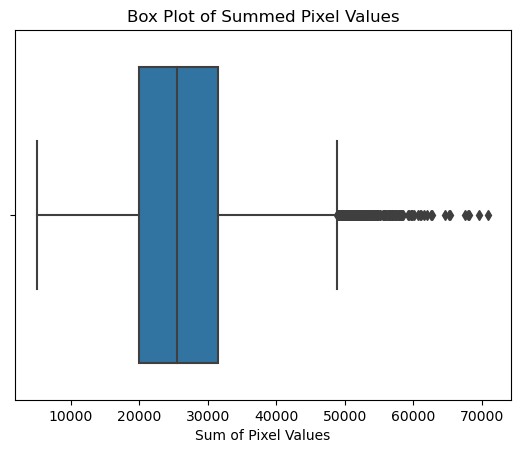

count      140.000000
mean     56014.321429
std       3808.971383
min      52092.000000
25%      53148.250000
50%      54790.000000
75%      57342.250000
max      70934.000000
dtype: float64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Calculate Z-scores for the sum of pixel values:
pixel_sum = test.iloc[1:, :].sum(axis=1)
z_scores = stats.zscore(pixel_sum)
outliers = pixel_sum[(z_scores > 3) | (z_scores < -3)]

# Plot the distribution of pixel sums:
sns.boxplot(x=pixel_sum)
plt.title('Box Plot of Summed Pixel Values')
plt.xlabel('Sum of Pixel Values')
plt.show()

print(outliers.describe())

There are 140 records with a z-score greater than 3. We will view random images from this set to see if they are unusual:

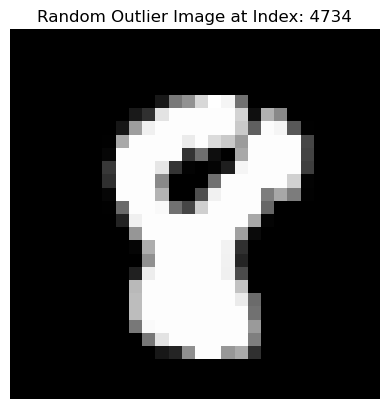

In [16]:
import matplotlib.pyplot as plt
import random

# Select a random index from the outliers
outlier_indexes = outliers.index
random_outlier_index = random.choice(outlier_indexes)

# Take the image data at the random index and reshape
image_data = train.iloc[random_outlier_index, 1:].values
image_matrix = image_data.reshape(28, 28)

# Display the image
plt.imshow(image_matrix, cmap='gray')
plt.title(f'Random Outlier Image at Index: {random_outlier_index}')
plt.axis('off')  # Turn off axis numbers
plt.show()

# Adopted from GPT-4

The outliers all appear to be handwritten digits. There are some with especially broad strokes. Many appear to be digits with more complexity (8,3,5 for example). We will not remove these outliers.

## Data Understanding 2

To better understand the data, we will visualize some aspects. We will look at the distribution of digits within the training data. We will also view some of the images to see what they look like.

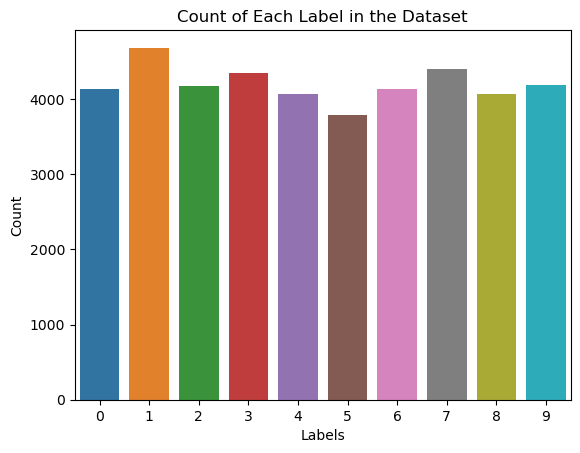

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot of digits
sns.countplot(x='label', data=train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label in the Dataset')

plt.show()


The digits in the training set appear uniformly distributed. Each label has approximately 4,000 samples or 10% of the dataset.

Here are some random images from the training set:

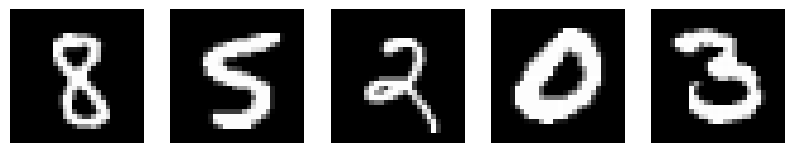

In [18]:
import numpy as np

# Display five random images from the training set:
def display_random_images(df, num_images):
    # Generate random indexes
    random_indexes = np.random.randint(0, len(df), num_images)

    # Retrieve random images by these indexes
    random_images = df.iloc[random_indexes, 1:].values

    # Reshape the random images to 28x28
    random_images = random_images.reshape(num_images, 28, 28)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

    for i in range(num_images):
        axes[i].imshow(random_images[i], cmap='gray')
        axes[i].axis('off')

    plt.show()
    
display_random_images(train, 5)

Above are five examples of what the images look like.

### Data Preparation

Next we will prepare the data for use in SciKit Learn. We will normalize the data by dividing each pixel value by 255, which will scale the values to between 0 and 1. We will also split the training set into training and validation subsets by using a Stratified Shuffle Split with 10% of the data used for validation.

In [19]:
from sklearn.model_selection import train_test_split

# Prepare the data for use in modelling:
y = train['label'].values
X = train.drop('label', axis=1).values
test_set = test.values

# Normalize the pixel data for both train and test:
X = X / 255.0
test_set = test_set / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.1, random_state=137, stratify=y)

**Consider PCA Here**

## Modeling and Evaluation 1

Train and adjust parameters

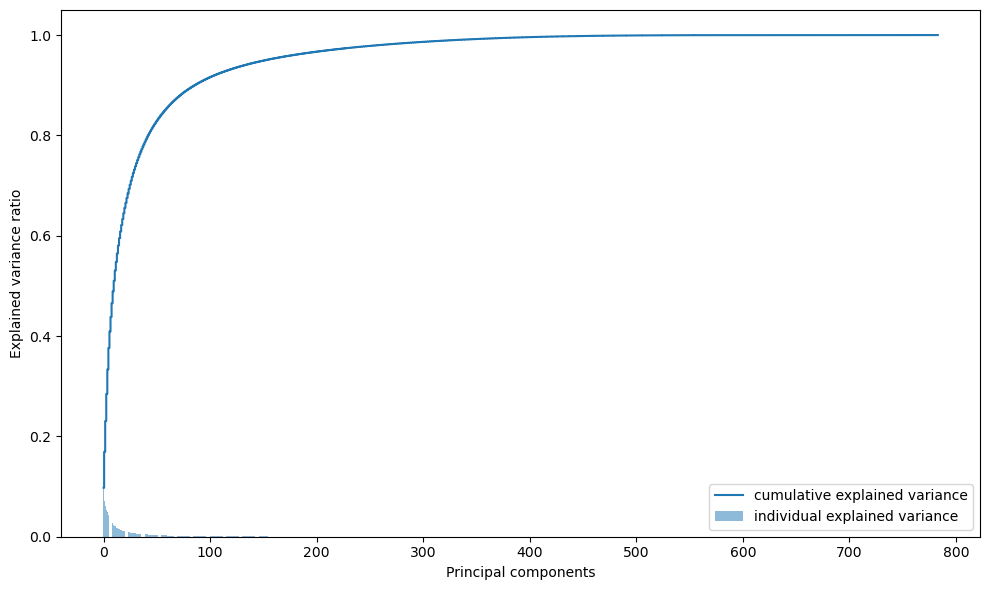

In [50]:
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X_train)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(cum_explained_var)), cum_explained_var, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# Define the number of components for PCA and the number of clusters for KMeans
n_components = 100  # Example value, adjust based on your requirements
n_clusters = len(np.unique(y_train))  # Assuming y_train contains your labels

# Create the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=137))
])


In [52]:
pipeline.fit(X_train)
clusters = pipeline.predict(X_train)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
cluster_labels = np.zeros_like(clusters)

for cluster in range(n_clusters):
    mask = (clusters == cluster)
    cluster_labels[mask] = mode(y_train[mask])[0]


In [54]:
accuracy = accuracy_score(y_train, cluster_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5815608465608466


In [55]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_train, cluster_labels)
print(cm)

# Accuracy per class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {accuracy:.4f}")


[[2679    2    3  161   23    0  824    3   24    0]
 [   0 4191    3    5    3    0    6    4    4    0]
 [  23  477 2591  177  124    0  200   45  122    0]
 [  13  287  102 2460  110    0  325   23  596    0]
 [   4  243   17    0 2054    0  186 1153    8    0]
 [  35  311    3 1174  220    0  990  147  535    0]
 [  46  169   20   20   41    0 3418    3    6    0]
 [  12  371   28    5 1161    0    8 2365   11    0]
 [  18  376   23  637  100    0  174  104 2225    0]
 [  29  207    6   43 1920    0   28 1488   48    0]]
Accuracy for class 0: 0.7204
Accuracy for class 1: 0.9941
Accuracy for class 2: 0.6893
Accuracy for class 3: 0.6282
Accuracy for class 4: 0.5604
Accuracy for class 5: 0.0000
Accuracy for class 6: 0.9181
Accuracy for class 7: 0.5971
Accuracy for class 8: 0.6084
Accuracy for class 9: 0.0000


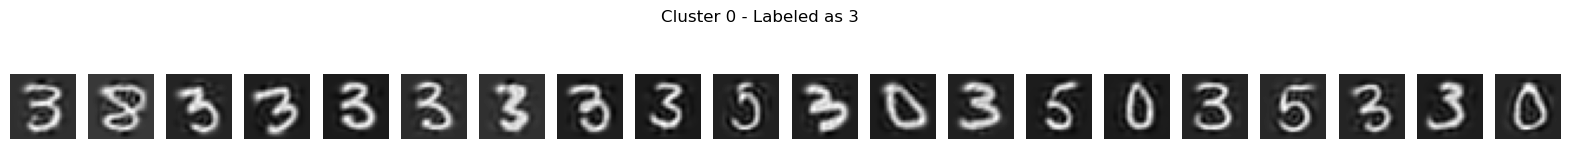

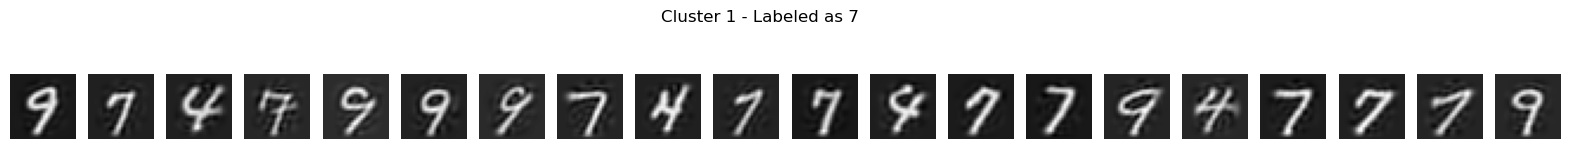

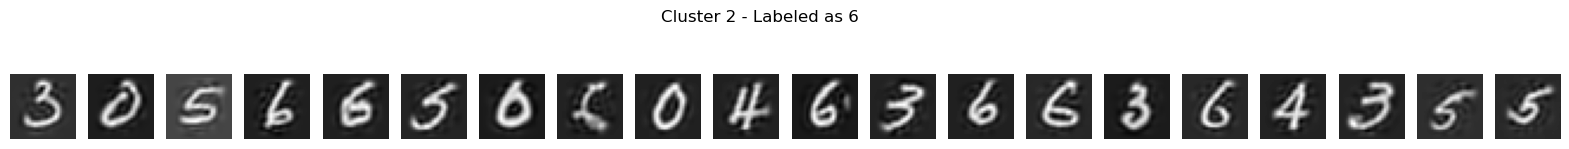

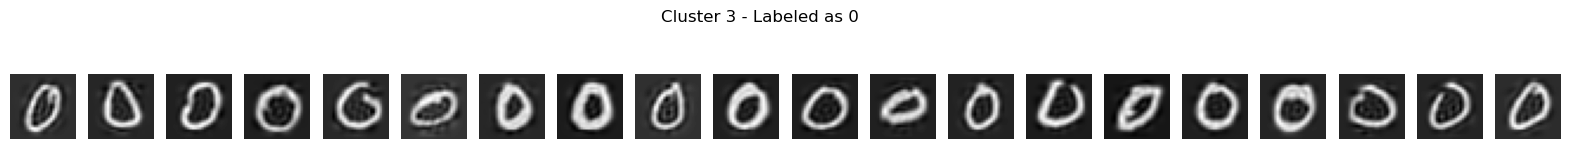

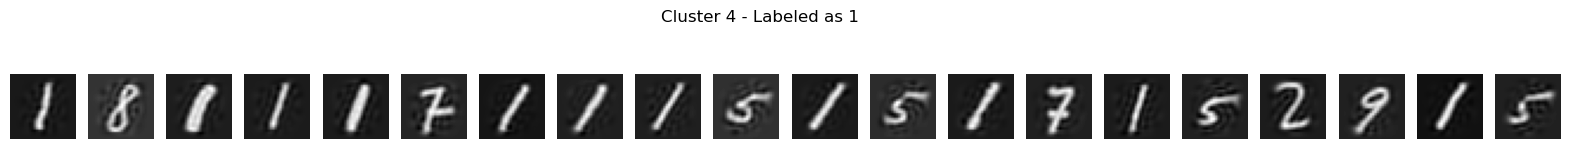

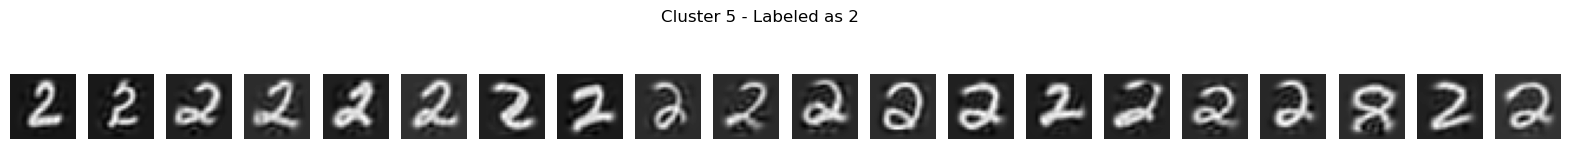

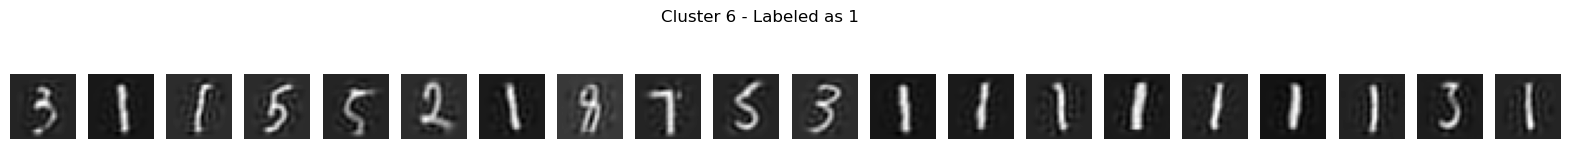

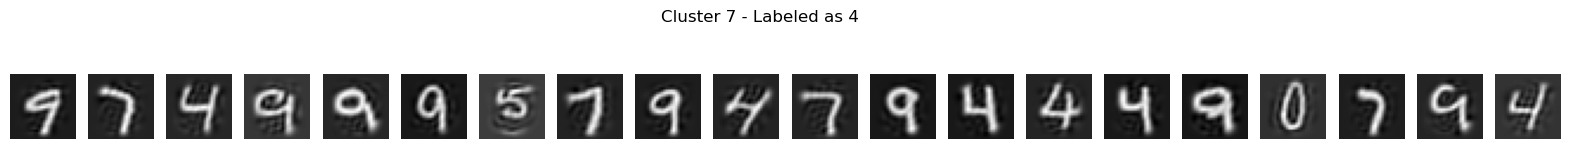

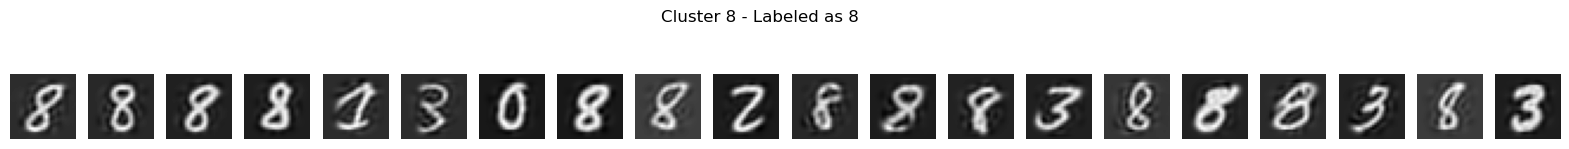

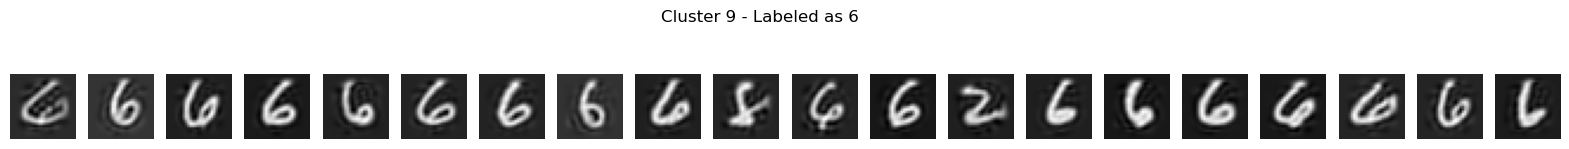

In [56]:
import matplotlib.pyplot as plt
import random

# Number of images per cluster to display
num_images = 20

# Access the PCA component from the pipeline
pca = pipeline.named_steps['pca']

for cluster in range(n_clusters):
    # Find indexes of images in this cluster
    indexes = np.where(clusters == cluster)[0]

    # Randomly select ten indexes
    selected_indexes = random.sample(list(indexes), min(len(indexes), num_images))

    # Plotting
    plt.figure(figsize=(20, 2))
    for i, index in enumerate(selected_indexes):
        # Retrieve the PCA-transformed data for the selected index
        pca_transformed_data = pca.transform(X_train[[index]])

        # Inverse transform to reconstruct the image
        reconstructed_image = pca.inverse_transform(pca_transformed_data)
        image_matrix = reconstructed_image.reshape(28, 28)  # Reshape

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_matrix, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Cluster {cluster} - Labeled as {cluster_labels[indexes[0]]}')
    plt.show()


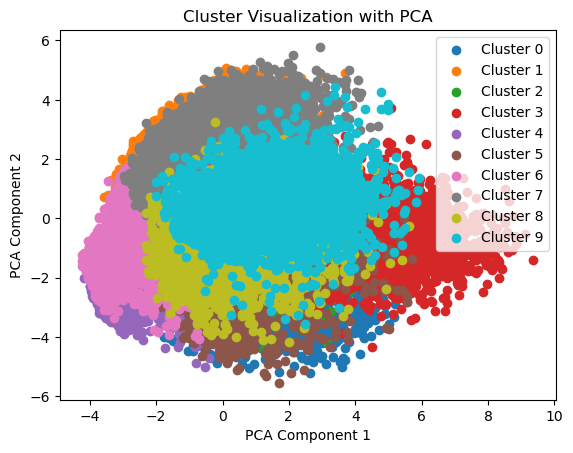

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Scatter plot
for cluster in range(n_clusters):
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Visualization with PCA')
plt.legend()
plt.show()


In [60]:
from sklearn.metrics import silhouette_score

# Calculating the silhouette score
silhouette = silhouette_score(X_train, clusters)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.0587


## Modeling and Evaluation 2

Evaluate and Compare

## Modeling and Evaluation 3

Visualize Results

## Modeling and Evaluation 4

Summarize the Ramifications

## Deployment

## Exceptional Work

Neural Network here for comparison purposes

## References

@misc{digit-recognizer,
    author = {AstroDave, Will Cukierski},
    title = {Digit Recognizer},
    publisher = {Kaggle},
    year = {2012},
    url = {https://kaggle.com/competitions/digit-recognizer}
}

@misc{MNIST,
    author = {Yann, LecCun, Corinna Cortes, Christopher J.C. Burges},
    title = {The MNIST Database of Handwritten Digits},
    publisher = {yan.lecun.com},
    url = {http://yann.lecun.com/exdb/mnist/}
}